In [13]:
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import utils
from tqdm import tqdm
import warnings

warnings.simplefilter('ignore', Image.DecompressionBombWarning)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
lr = 5e-4
n_epochs = 100
training_path = "/DAS_Storage4/hyungseok/Training"
validation_path = "/DAS_Storage4/hyungseok/Validation"
path = "/DAS_Storage4/hyungseok/2020-02-140.동의보감약초_sample/img"

In [3]:
device = torch.device("cuda:3")

In [4]:
train_trans = transforms.Compose([transforms.Resize((128,128)),
                           transforms.ToTensor(),     
                           transforms.RandomHorizontalFlip(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
valid_trans = transforms.Compose([transforms.Resize((128,128)),
                           transforms.ToTensor(),                           
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
trainset = torchvision.datasets.ImageFolder(root = training_path,
                                           transform = train_trans)
validset = torchvision.datasets.ImageFolder(root = validation_path,
                                           transform = valid_trans)
train_loader = DataLoader(trainset, batch_size = 256, shuffle = True, num_workers = 4)
valid_loader = DataLoader(validset, batch_size = 256, shuffle = False, num_workers = 4)

In [5]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2


        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(
                x
            )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x


class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x


class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x


class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).
    in_chans : int
        Number of input channels.
    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=128,
            patch_size=16,
            in_chans=3,
            n_classes=128,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

In [6]:
model = VisionTransformer().to(device)
utils.init_weights(model, init_type='uniform')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.9), eps = 1e-9, weight_decay = 1e-5)

In [7]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for epoch in range(n_epochs):
    
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    running_val_loss = 0.0
    valid_correct = 0
    valid_total = 0
    model.train()
    
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        output = model(x)
        
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        train_total += y.size(0)
        train_correct += (predicted == y).sum().item()
        
    with torch.no_grad():
        model.eval()

        for idx, (x, y) in tqdm(enumerate(valid_loader)):

            x, y = x.to(device), y.to(device)

            valid_output = model(x)

            valid_loss = criterion(valid_output, y)

            running_val_loss += valid_loss.item()

            _, predicted = torch.max(valid_output.data, 1)
            valid_total += y.size(0)
            valid_correct += (predicted == y).sum().item()
            
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss
    }, 'model/VIT/{}-new_model.pt'.format(epoch+1))


            
        
    print('Epoch {}/{}, Train_Acc: {:.3f}, Train_Loss : {:.6f}, valid_Acc : {:.3f}, Valid_Loss : {:.6f}'.format(epoch+1,n_epochs, 
                                                                                                              train_correct/train_total,
                                                                                                              running_loss / len(train_loader),
                                                                                                             valid_correct/valid_total,
                                                                                                              running_val_loss / len(valid_loader)
                                                                                                             ))
    
    train_loss_list.append(running_loss / len(train_loader))
    valid_loss_list.append(running_val_loss / len(valid_loader))
    train_acc_list.append(train_correct/train_total)
    valid_acc_list.append(valid_correct/valid_total)
    
        

2072it [1:36:36,  2.80s/it]
259it [12:17,  2.85s/it]


Epoch 1/100, Train_Acc: 0.175, Train_Loss : 3.743952, valid_Acc : 0.287, Valid_Loss : 3.106652


2072it [1:36:17,  2.79s/it]
259it [12:13,  2.83s/it]


Epoch 2/100, Train_Acc: 0.370, Train_Loss : 2.699234, valid_Acc : 0.412, Valid_Loss : 2.470667


2072it [1:35:49,  2.77s/it]
259it [11:55,  2.76s/it]


Epoch 3/100, Train_Acc: 0.474, Train_Loss : 2.191531, valid_Acc : 0.498, Valid_Loss : 2.058879


2072it [1:36:04,  2.78s/it]
259it [12:34,  2.91s/it]


Epoch 4/100, Train_Acc: 0.541, Train_Loss : 1.869250, valid_Acc : 0.552, Valid_Loss : 1.819844


2072it [1:36:40,  2.80s/it]
259it [12:29,  2.89s/it]


Epoch 5/100, Train_Acc: 0.596, Train_Loss : 1.617015, valid_Acc : 0.598, Valid_Loss : 1.610508


2072it [1:35:44,  2.77s/it]
259it [12:27,  2.89s/it]


Epoch 6/100, Train_Acc: 0.642, Train_Loss : 1.406469, valid_Acc : 0.639, Valid_Loss : 1.425963


2072it [1:35:55,  2.78s/it]
259it [14:20,  3.32s/it]


Epoch 7/100, Train_Acc: 0.684, Train_Loss : 1.220815, valid_Acc : 0.668, Valid_Loss : 1.302921


2072it [1:38:47,  2.86s/it]
259it [12:52,  2.98s/it]


Epoch 8/100, Train_Acc: 0.721, Train_Loss : 1.064620, valid_Acc : 0.702, Valid_Loss : 1.157709


2072it [1:38:59,  2.87s/it]
259it [12:09,  2.82s/it]


Epoch 9/100, Train_Acc: 0.753, Train_Loss : 0.931731, valid_Acc : 0.727, Valid_Loss : 1.062555


2072it [1:39:14,  2.87s/it]
259it [12:17,  2.85s/it]


Epoch 10/100, Train_Acc: 0.781, Train_Loss : 0.814246, valid_Acc : 0.742, Valid_Loss : 0.990220


2072it [1:42:39,  2.97s/it]
259it [12:12,  2.83s/it]


Epoch 11/100, Train_Acc: 0.806, Train_Loss : 0.713405, valid_Acc : 0.758, Valid_Loss : 0.937145


2072it [1:41:00,  2.92s/it]
259it [12:31,  2.90s/it]


Epoch 12/100, Train_Acc: 0.827, Train_Loss : 0.629319, valid_Acc : 0.775, Valid_Loss : 0.870165


2072it [1:41:09,  2.93s/it]
259it [12:22,  2.87s/it]


Epoch 13/100, Train_Acc: 0.845, Train_Loss : 0.553346, valid_Acc : 0.794, Valid_Loss : 0.803552


2072it [1:38:42,  2.86s/it]
259it [12:29,  2.89s/it]


Epoch 14/100, Train_Acc: 0.861, Train_Loss : 0.491489, valid_Acc : 0.809, Valid_Loss : 0.750972


2072it [1:37:29,  2.82s/it]
259it [12:25,  2.88s/it]


Epoch 15/100, Train_Acc: 0.875, Train_Loss : 0.439054, valid_Acc : 0.813, Valid_Loss : 0.737286


2072it [1:40:28,  2.91s/it]
259it [12:36,  2.92s/it]


Epoch 16/100, Train_Acc: 0.886, Train_Loss : 0.393973, valid_Acc : 0.818, Valid_Loss : 0.709527


2072it [1:40:32,  2.91s/it]
259it [12:27,  2.88s/it]


Epoch 17/100, Train_Acc: 0.896, Train_Loss : 0.354502, valid_Acc : 0.826, Valid_Loss : 0.706607


2072it [1:40:02,  2.90s/it]
259it [12:26,  2.88s/it]


Epoch 18/100, Train_Acc: 0.904, Train_Loss : 0.321089, valid_Acc : 0.835, Valid_Loss : 0.669846


2072it [1:39:58,  2.89s/it]
259it [12:04,  2.80s/it]


Epoch 19/100, Train_Acc: 0.912, Train_Loss : 0.292210, valid_Acc : 0.837, Valid_Loss : 0.670720


2072it [1:40:24,  2.91s/it]
259it [12:55,  2.99s/it]


Epoch 20/100, Train_Acc: 0.919, Train_Loss : 0.267004, valid_Acc : 0.842, Valid_Loss : 0.664114


2072it [1:43:35,  3.00s/it]
259it [12:13,  2.83s/it]


Epoch 21/100, Train_Acc: 0.925, Train_Loss : 0.244980, valid_Acc : 0.846, Valid_Loss : 0.648646


2072it [1:43:04,  2.98s/it]
259it [13:35,  3.15s/it]


Epoch 22/100, Train_Acc: 0.929, Train_Loss : 0.228222, valid_Acc : 0.844, Valid_Loss : 0.668813


2072it [1:42:02,  2.95s/it]
259it [12:12,  2.83s/it]


Epoch 23/100, Train_Acc: 0.934, Train_Loss : 0.212055, valid_Acc : 0.847, Valid_Loss : 0.667729


2072it [1:38:44,  2.86s/it]
259it [12:20,  2.86s/it]


Epoch 24/100, Train_Acc: 0.938, Train_Loss : 0.197239, valid_Acc : 0.856, Valid_Loss : 0.639544


2072it [1:37:39,  2.83s/it]
259it [12:20,  2.86s/it]


Epoch 25/100, Train_Acc: 0.941, Train_Loss : 0.185861, valid_Acc : 0.854, Valid_Loss : 0.656638


2072it [1:38:46,  2.86s/it]
259it [12:07,  2.81s/it]


Epoch 26/100, Train_Acc: 0.944, Train_Loss : 0.175549, valid_Acc : 0.854, Valid_Loss : 0.656533


2072it [1:39:45,  2.89s/it]
259it [12:17,  2.85s/it]


Epoch 27/100, Train_Acc: 0.947, Train_Loss : 0.165695, valid_Acc : 0.858, Valid_Loss : 0.652541


2072it [1:36:57,  2.81s/it]
259it [12:00,  2.78s/it]


Epoch 28/100, Train_Acc: 0.948, Train_Loss : 0.158424, valid_Acc : 0.861, Valid_Loss : 0.641026


2072it [1:36:46,  2.80s/it]
259it [12:00,  2.78s/it]


Epoch 29/100, Train_Acc: 0.951, Train_Loss : 0.150763, valid_Acc : 0.861, Valid_Loss : 0.648365


2072it [1:36:06,  2.78s/it]
259it [12:18,  2.85s/it]


Epoch 30/100, Train_Acc: 0.953, Train_Loss : 0.144828, valid_Acc : 0.861, Valid_Loss : 0.652767


2072it [1:40:11,  2.90s/it]
259it [12:16,  2.84s/it]


Epoch 31/100, Train_Acc: 0.955, Train_Loss : 0.138851, valid_Acc : 0.866, Valid_Loss : 0.642048


2072it [1:39:09,  2.87s/it]
259it [12:36,  2.92s/it]


Epoch 32/100, Train_Acc: 0.956, Train_Loss : 0.134284, valid_Acc : 0.866, Valid_Loss : 0.640060


2072it [1:37:52,  2.83s/it]
259it [12:34,  2.91s/it]


Epoch 33/100, Train_Acc: 0.958, Train_Loss : 0.129174, valid_Acc : 0.863, Valid_Loss : 0.655064


2072it [1:36:42,  2.80s/it]
259it [12:17,  2.85s/it]


Epoch 34/100, Train_Acc: 0.959, Train_Loss : 0.125136, valid_Acc : 0.869, Valid_Loss : 0.643759


2072it [1:38:36,  2.86s/it]
259it [12:20,  2.86s/it]


Epoch 35/100, Train_Acc: 0.960, Train_Loss : 0.122033, valid_Acc : 0.869, Valid_Loss : 0.641226


2072it [1:38:15,  2.85s/it]
259it [12:14,  2.84s/it]


Epoch 36/100, Train_Acc: 0.961, Train_Loss : 0.117760, valid_Acc : 0.865, Valid_Loss : 0.657442


2072it [1:37:12,  2.81s/it]
259it [12:25,  2.88s/it]


Epoch 37/100, Train_Acc: 0.962, Train_Loss : 0.115409, valid_Acc : 0.868, Valid_Loss : 0.655825


2072it [1:38:10,  2.84s/it]
259it [12:24,  2.87s/it]


Epoch 38/100, Train_Acc: 0.964, Train_Loss : 0.111455, valid_Acc : 0.872, Valid_Loss : 0.639657


2072it [1:38:12,  2.84s/it]
259it [12:40,  2.94s/it]


Epoch 39/100, Train_Acc: 0.964, Train_Loss : 0.109616, valid_Acc : 0.871, Valid_Loss : 0.642396


2072it [1:38:12,  2.84s/it]
259it [12:25,  2.88s/it]


Epoch 40/100, Train_Acc: 0.965, Train_Loss : 0.106114, valid_Acc : 0.872, Valid_Loss : 0.641092


2072it [1:37:01,  2.81s/it]
259it [12:23,  2.87s/it]


Epoch 41/100, Train_Acc: 0.966, Train_Loss : 0.104719, valid_Acc : 0.870, Valid_Loss : 0.643611


2072it [1:39:05,  2.87s/it]
259it [12:19,  2.86s/it]


Epoch 42/100, Train_Acc: 0.967, Train_Loss : 0.102311, valid_Acc : 0.877, Valid_Loss : 0.628649


2072it [1:38:32,  2.85s/it]
259it [12:30,  2.90s/it]


Epoch 43/100, Train_Acc: 0.967, Train_Loss : 0.099784, valid_Acc : 0.876, Valid_Loss : 0.616355


2072it [1:37:55,  2.84s/it]
259it [12:24,  2.88s/it]


Epoch 44/100, Train_Acc: 0.968, Train_Loss : 0.098433, valid_Acc : 0.877, Valid_Loss : 0.623195


2072it [1:38:35,  2.86s/it]
259it [12:20,  2.86s/it]


Epoch 45/100, Train_Acc: 0.968, Train_Loss : 0.096269, valid_Acc : 0.880, Valid_Loss : 0.599243


2072it [1:38:07,  2.84s/it]
259it [12:14,  2.84s/it]


Epoch 46/100, Train_Acc: 0.969, Train_Loss : 0.094018, valid_Acc : 0.880, Valid_Loss : 0.617523


2072it [1:38:31,  2.85s/it]
259it [12:17,  2.85s/it]


Epoch 47/100, Train_Acc: 0.970, Train_Loss : 0.092802, valid_Acc : 0.877, Valid_Loss : 0.620922


2072it [1:38:37,  2.86s/it]
259it [12:32,  2.91s/it]


Epoch 48/100, Train_Acc: 0.970, Train_Loss : 0.091341, valid_Acc : 0.880, Valid_Loss : 0.612374


2072it [1:38:54,  2.86s/it]
259it [12:21,  2.86s/it]


Epoch 49/100, Train_Acc: 0.971, Train_Loss : 0.089854, valid_Acc : 0.878, Valid_Loss : 0.623405


2072it [1:37:59,  2.84s/it]
259it [12:28,  2.89s/it]


Epoch 50/100, Train_Acc: 0.971, Train_Loss : 0.088434, valid_Acc : 0.882, Valid_Loss : 0.620186


2072it [1:38:24,  2.85s/it]
259it [12:28,  2.89s/it]


Epoch 51/100, Train_Acc: 0.971, Train_Loss : 0.087416, valid_Acc : 0.883, Valid_Loss : 0.604696


2072it [1:38:03,  2.84s/it]
259it [12:34,  2.91s/it]


Epoch 52/100, Train_Acc: 0.972, Train_Loss : 0.085459, valid_Acc : 0.878, Valid_Loss : 0.628909


2072it [1:37:03,  2.81s/it]
259it [12:34,  2.91s/it]


Epoch 53/100, Train_Acc: 0.972, Train_Loss : 0.085295, valid_Acc : 0.877, Valid_Loss : 0.626931


2072it [1:38:04,  2.84s/it]
259it [12:29,  2.89s/it]


Epoch 54/100, Train_Acc: 0.972, Train_Loss : 0.083699, valid_Acc : 0.878, Valid_Loss : 0.629902


2072it [1:38:48,  2.86s/it]
259it [12:31,  2.90s/it]


Epoch 55/100, Train_Acc: 0.973, Train_Loss : 0.082167, valid_Acc : 0.882, Valid_Loss : 0.625060


2072it [1:37:44,  2.83s/it]
259it [12:27,  2.89s/it]


Epoch 56/100, Train_Acc: 0.973, Train_Loss : 0.081660, valid_Acc : 0.883, Valid_Loss : 0.608297


2072it [1:38:02,  2.84s/it]
259it [12:28,  2.89s/it]


Epoch 57/100, Train_Acc: 0.974, Train_Loss : 0.080220, valid_Acc : 0.884, Valid_Loss : 0.604645


2072it [1:38:24,  2.85s/it]
259it [12:30,  2.90s/it]


Epoch 58/100, Train_Acc: 0.974, Train_Loss : 0.078722, valid_Acc : 0.882, Valid_Loss : 0.618158


2072it [1:38:25,  2.85s/it]
259it [12:24,  2.87s/it]


Epoch 59/100, Train_Acc: 0.974, Train_Loss : 0.078572, valid_Acc : 0.884, Valid_Loss : 0.616525


2072it [1:37:01,  2.81s/it]
259it [12:32,  2.91s/it]


Epoch 60/100, Train_Acc: 0.975, Train_Loss : 0.076795, valid_Acc : 0.884, Valid_Loss : 0.606063


2072it [1:36:50,  2.80s/it]
259it [12:54,  2.99s/it]


Epoch 61/100, Train_Acc: 0.975, Train_Loss : 0.076997, valid_Acc : 0.887, Valid_Loss : 0.593840


2072it [1:39:34,  2.88s/it]
259it [12:10,  2.82s/it]


Epoch 62/100, Train_Acc: 0.975, Train_Loss : 0.074778, valid_Acc : 0.887, Valid_Loss : 0.598301


2072it [1:35:03,  2.75s/it]
259it [12:04,  2.80s/it]


Epoch 63/100, Train_Acc: 0.976, Train_Loss : 0.074353, valid_Acc : 0.887, Valid_Loss : 0.606676


2072it [1:35:35,  2.77s/it]
259it [12:01,  2.79s/it]


Epoch 64/100, Train_Acc: 0.976, Train_Loss : 0.073769, valid_Acc : 0.884, Valid_Loss : 0.615638


2072it [1:35:18,  2.76s/it]
259it [12:01,  2.79s/it]


Epoch 65/100, Train_Acc: 0.976, Train_Loss : 0.073628, valid_Acc : 0.885, Valid_Loss : 0.607823


2072it [1:36:08,  2.78s/it]
259it [12:02,  2.79s/it]


Epoch 66/100, Train_Acc: 0.976, Train_Loss : 0.072640, valid_Acc : 0.885, Valid_Loss : 0.601632


2072it [1:36:23,  2.79s/it]
259it [12:17,  2.85s/it]


Epoch 67/100, Train_Acc: 0.977, Train_Loss : 0.071185, valid_Acc : 0.888, Valid_Loss : 0.595430


2072it [1:36:38,  2.80s/it]
259it [12:07,  2.81s/it]


Epoch 68/100, Train_Acc: 0.977, Train_Loss : 0.071185, valid_Acc : 0.887, Valid_Loss : 0.607640


2072it [1:36:30,  2.79s/it]
259it [12:01,  2.79s/it]


Epoch 69/100, Train_Acc: 0.977, Train_Loss : 0.070473, valid_Acc : 0.887, Valid_Loss : 0.592811


2072it [1:35:29,  2.77s/it]
259it [12:11,  2.82s/it]


Epoch 70/100, Train_Acc: 0.977, Train_Loss : 0.069281, valid_Acc : 0.886, Valid_Loss : 0.605251


2072it [1:36:29,  2.79s/it]
259it [12:17,  2.85s/it]


Epoch 71/100, Train_Acc: 0.977, Train_Loss : 0.069486, valid_Acc : 0.887, Valid_Loss : 0.607696


2072it [1:37:00,  2.81s/it]
259it [12:14,  2.84s/it]


Epoch 72/100, Train_Acc: 0.978, Train_Loss : 0.068420, valid_Acc : 0.890, Valid_Loss : 0.594306


2072it [1:39:22,  2.88s/it]
259it [12:19,  2.86s/it]


Epoch 73/100, Train_Acc: 0.978, Train_Loss : 0.067824, valid_Acc : 0.893, Valid_Loss : 0.571765


2072it [1:38:33,  2.85s/it]
259it [12:13,  2.83s/it]


Epoch 74/100, Train_Acc: 0.978, Train_Loss : 0.067023, valid_Acc : 0.884, Valid_Loss : 0.616624


2072it [1:38:32,  2.85s/it]
259it [12:24,  2.88s/it]


Epoch 75/100, Train_Acc: 0.978, Train_Loss : 0.067584, valid_Acc : 0.890, Valid_Loss : 0.587293


2072it [1:56:04,  3.36s/it]
259it [12:52,  2.98s/it]


Epoch 76/100, Train_Acc: 0.978, Train_Loss : 0.066816, valid_Acc : 0.889, Valid_Loss : 0.588687


2072it [1:40:57,  2.92s/it]
259it [12:34,  2.91s/it]


Epoch 77/100, Train_Acc: 0.979, Train_Loss : 0.065579, valid_Acc : 0.884, Valid_Loss : 0.608520


2072it [1:43:18,  2.99s/it]
259it [12:36,  2.92s/it]


Epoch 78/100, Train_Acc: 0.979, Train_Loss : 0.065016, valid_Acc : 0.890, Valid_Loss : 0.588409


2072it [1:40:33,  2.91s/it]
259it [12:34,  2.92s/it]


Epoch 79/100, Train_Acc: 0.979, Train_Loss : 0.064814, valid_Acc : 0.890, Valid_Loss : 0.590025


2072it [1:39:43,  2.89s/it]
259it [12:55,  2.99s/it]


Epoch 80/100, Train_Acc: 0.979, Train_Loss : 0.064162, valid_Acc : 0.893, Valid_Loss : 0.579082


2072it [1:39:00,  2.87s/it]
259it [12:40,  2.94s/it]


Epoch 81/100, Train_Acc: 0.979, Train_Loss : 0.064193, valid_Acc : 0.889, Valid_Loss : 0.596779


2072it [1:37:12,  2.82s/it]
259it [12:21,  2.86s/it]


Epoch 82/100, Train_Acc: 0.979, Train_Loss : 0.063435, valid_Acc : 0.893, Valid_Loss : 0.577160


2072it [1:36:52,  2.81s/it]
259it [12:42,  2.95s/it]


Epoch 83/100, Train_Acc: 0.980, Train_Loss : 0.062367, valid_Acc : 0.890, Valid_Loss : 0.588911


2072it [1:37:04,  2.81s/it]
259it [12:35,  2.92s/it]


Epoch 84/100, Train_Acc: 0.979, Train_Loss : 0.062749, valid_Acc : 0.888, Valid_Loss : 0.604310


2072it [1:39:50,  2.89s/it]
259it [12:45,  2.95s/it]


Epoch 85/100, Train_Acc: 0.980, Train_Loss : 0.062921, valid_Acc : 0.887, Valid_Loss : 0.605016


2072it [1:38:34,  2.85s/it]
259it [12:17,  2.85s/it]


Epoch 86/100, Train_Acc: 0.980, Train_Loss : 0.061842, valid_Acc : 0.892, Valid_Loss : 0.587611


1701it [1:24:03,  2.97s/it]


KeyboardInterrupt: 

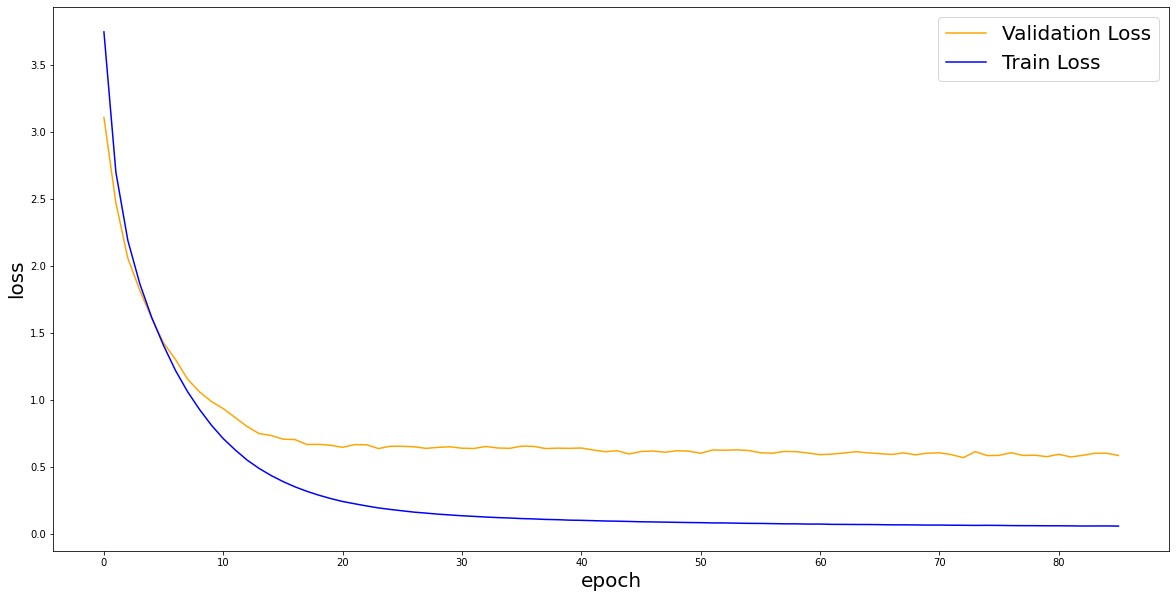

In [17]:
x_len = np.arange(len(valid_loss_list))
plt.figure(figsize=(20,10))
plt.plot(x_len, valid_loss_list, c='orange', label="Validation Loss")
plt.plot(x_len, train_loss_list, c='blue', label="Train Loss")
plt.xticks(np.arange(0, 90, 10))
#plt.title('With pretraining', fontsize=20)
plt.legend(loc='upper right')
plt.legend(loc='best', ncol=1, fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

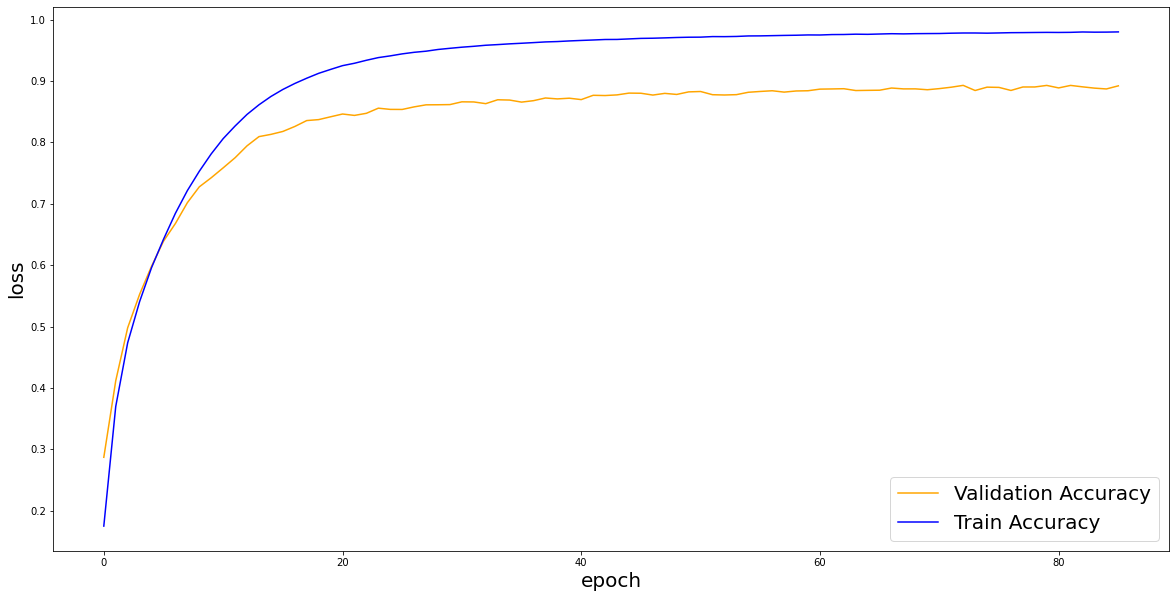

In [19]:
x_len = np.arange(len(valid_acc_list))
plt.figure(figsize=(20,10))
plt.plot(x_len, valid_acc_list, c='orange', label="Validation Accuracy")
plt.plot(x_len, train_acc_list, c='blue', label="Train Accuracy")
#plt.title('With pretraining', fontsize=20)
plt.legend(loc='upper right')
plt.legend(loc='best', ncol=1, fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()